# Lecture 7 — More Statistical Learning

In this lecture, we will expand our statistical learning toolkit by exploring:
1. **More on Data Scikit-Learn Data Processing** — `Pipeline` and `ColumnTransformer`
1. **Time Series Data** — handling temporal dependencies and proper validation strategies
2. **Count/Rate Data** — Poisson regression for modeling event counts
3. **More Powerful Models** — tree-based models and neural networks
4. **Model Comparison** — systematic evaluation across different model families

We'll work through a complete bike sharing demand prediction problem that demonstrates these concepts in practice.

# Announcements
1. The homework 1 was due last Friday.
2. The homework 2 will be released by the end of this week, and you will have until Nov. 28 (Friday) to submit it.
3. You can use the late days for the homework 2 as well.
4. The grading due date (for me) will be mid-December. So please do submit all the homeworks and attendance forms by Dec. 14 (Sunday).

In [53]:
from __future__ import annotations

# Standard library
from pathlib import Path
import warnings
import re

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import fetch_openml, make_regression
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PoissonRegressor, Ridge, LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.metrics import mean_poisson_deviance
from sklearn.inspection import permutation_importance

from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.patches import Patch

from IPython.display import HTML as _IPY_HTML

In [54]:
# Classroom settings (adjust to fit a 50-minute session)
FAST_MODE = True            # Keep True for class; set False for full runs
SAMPLE_N = None             # Optionally cap rows (e.g., 15000); None uses all
N_SPLITS = 3                # TimeSeriesSplit folds (smaller = faster)
ENABLE_DOC_IFRAMES = False  # Avoid network-heavy iframes during class
RUN_TUNING = False          # Skip hyperparameter tuning live
ENABLED_MODELS = [
    # Select the subset of models to run.
    "Ridge", "PoissonReg", "HistGBR", "RandomForest", "MLP", "KNN"
]

print("Classroom settings:")
print(f"  FAST_MODE={FAST_MODE}, SAMPLE_N={SAMPLE_N}, N_SPLITS={N_SPLITS}")
print(f"  ENABLE_DOC_IFRAMES={ENABLE_DOC_IFRAMES}, RUN_TUNING={RUN_TUNING}")
print(f"  ENABLED_MODELS={ENABLED_MODELS}")

# Override HTML display to skip iframes when disabled
try:
    def HTML(arg):
        if ENABLE_DOC_IFRAMES:
            return _IPY_HTML(arg)
        # Try to extract URL to print
        try:
            m = re.search(r'src=\"([^\"]+)\"', arg)
            url = m.group(1) if m else None
        except Exception:
            url = None
        print("Docs iframe skipped (ENABLE_DOC_IFRAMES=False)." + (f" See: {url}" if url else ""))
        return None
except Exception:
    pass


# Setup the computational environment
warnings.filterwarnings("ignore")

# Fix random seed for reproducibility
RANDOM_STATE = 42

# Create outputs dir
Path("../outputs").mkdir(parents=True, exist_ok=True)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("Setup complete.")

Classroom settings:
  FAST_MODE=True, SAMPLE_N=None, N_SPLITS=3
  ENABLE_DOC_IFRAMES=False, RUN_TUNING=False
  ENABLED_MODELS=['Ridge', 'PoissonReg', 'HistGBR', 'RandomForest', 'MLP', 'KNN']
Setup complete.


## Pipeline primer: why and how

Pipelines let us bundle preprocessing and modeling into one object, preventing data leakage and ensuring reproducible transformations during cross-validation and deployment.

- Encapsulation: preprocessing + model in one estimator
- No leakage: transformers fit on training folds only
- Reproducible: identical steps for validation/test

Minimal skeleton:
```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
])

model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SomeRegressor()),
])
# model_pipeline.fit(X_train, y_train)
# y_pred = model_pipeline.predict(X_test)
```

Docs: Pipeline (`https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html`), ColumnTransformer (`https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html`)


In [55]:
print("Imports complete!")

Imports complete!


# All-in-one Data Preprocessing with `ColumnTransformer`

**Why `ColumnTransformer`?**

Real-world datasets rarely come with uniform data types. You'll often have:
- **Numerical features** (age, income, temperature) that need scaling or normalization
- **Categorical features** (city, education level, product type) that need encoding
- **Mixed pipelines** where different columns require different preprocessing steps

**The Problem:** Manually splitting your DataFrame, transforming each subset, and reassembling is error-prone and tedious.

You can always do the following, split dataframes into columns, transform each group, and concatenate the results:
```python
# Manually split and transform
X_num = X[numeric_features]
X_cat = X[categorical_features]
X_num_transformed = scaler.fit_transform(X_num)
X_cat_transformed = encoder.fit_transform(X_cat)
X_transformed = np.concatenate([X_num_transformed, X_cat_transformed], axis=1)
```

**The Solution:** `ColumnTransformer` lets you specify which transformations apply to which columns in a single, clean object. It:
- Applies different transformers to different column subsets
- Handles the splitting and recombining automatically
- Integrates seamlessly with `Pipeline` (covered on next slide) for end-to-end workflows
- Preserves column order and makes your preprocessing reproducible

Key Idea: Think of it as a **router** that sends each column through the right preprocessing step, then concatenates the results.


In [56]:
# Example: ColumnTransformer for mixed data types
# Suppose we have numerical and categorical columns

# Sample data
sample_data = pd.DataFrame({
    'age': [25, 30, 35, 40],
    'experience_years': [2, 5, 10, 15],
    'city': ['SF', 'NYC', 'LA', 'SF'],
    'education': ['BS', 'MS', 'PhD', 'BS']
})

sample_data

,age,experience_years,city,education
0,25,2,SF,BS
1,30,5,NYC,MS
2,35,10,LA,PhD
3,40,15,SF,BS


In [57]:
# Define which columns get which transformations
numeric_features = ['age', 'experience_years']
categorical_features = ['city', 'education']

**StandardScaler Formula:**

For each feature $x$, StandardScaler transforms it to $z$ using:

$$z = \frac{x - \mu}{\sigma}$$

where:
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

This centers the data around 0 and scales it to unit variance.

**MinMaxScaler Formula:**

For each feature $x$, MinMaxScaler transforms it to $x'$ using:

$$x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$

where:
- $x_{\min}$ is the minimum value of the feature
- $x_{\max}$ is the maximum value of the feature

This scales the data to a fixed range, typically [0, 1].


```python
ColumnTransformer(
    transformers=[
        # (<A NICE NAME FOR THE TRANSFORMATION>, <TRANSFORMER>, <COLUMNS>)
    ],
    remainder='passthrough'  # Keep any other columns as-is
)
```

In [58]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical column processor', StandardScaler(), numeric_features),
        ('categorical column processor', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep any other columns as-is
)

In [59]:
# set the output of the preprocessor to be a pandas dataframe, you can set to other types e.g., numpy array.
# by default, it outputs a numpy array (more memory efficient!)
# here I set to pandas dataframe for better display.
preprocessor.set_output(transform='pandas')

,transformers,"[('numerical column processor', ...), ('categorical column processor', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [60]:
preprocessor

,transformers,"[('numerical column processor', ...), ('categorical column processor', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [61]:
# Fit and transform
X_transformed = preprocessor.fit_transform(sample_data)
print("Original shape:", sample_data.shape)
print("Transformed shape:", X_transformed.shape)
display(HTML(X_transformed.to_html()))

Original shape: (4, 4)
Transformed shape: (4, 6)
Docs iframe skipped (ENABLE_DOC_IFRAMES=False).


None

# Pipeline
- **Pipeline** lets you chain multiple scikit-learn objects together into a single object (similar to `torch.nn.Sequential` if you are familiar with PyTorch).
- You can chain multiple transformation steps together, and then put a model (e.g., `LogisticRegression`) on top of it.
- Useful when you need to apply several preprocessing steps in sequence (e.g., standardize then scale)
- Keeps your code cleaner and easier to maintain
- Can be nested inside a `ColumnTransformer` to apply multi-step transformations to specific columns
- Ensures that all steps are applied consistently during both training and prediction


## Example: Multi-step transformation with nested pipelines

In [62]:
# Example: Multi-step transformation with nested pipelines
# You can wrap multiple transformers together using Pipeline

# Create a multi-step pipeline for numerical features
# First standardize, then scale to [0, 1] range
numerical_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('minmax', MinMaxScaler())
])

# Create a new ColumnTransformer with the multi-step pipeline
preprocessor_multistep = ColumnTransformer(
    transformers=[
        ('numerical multi-step', numerical_pipeline, numeric_features),
        ('categorical column processor', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Set output format and transform
preprocessor_multistep.set_output(transform='pandas')
X_transformed_multistep = preprocessor_multistep.fit_transform(sample_data)

print("Multi-step transformation result:")
print("Shape:", X_transformed_multistep.shape)
display(HTML(X_transformed_multistep.to_html()))


Multi-step transformation result:
Shape: (4, 6)
Docs iframe skipped (ENABLE_DOC_IFRAMES=False).


None

## Example: Pipeline with Model

Now let's see the real power of pipelines: combining preprocessing and modeling into a single object.

- **End-to-end workflow**: You can chain your `ColumnTransformer` (or any preprocessor) with a model like `LogisticRegression`
- **Single `.fit()` call**: The pipeline automatically applies all preprocessing steps and then trains the model
- **Consistent predictions**: When you call `.predict()`, the pipeline applies the same transformations to new data before making predictions
- **Cleaner code**: No need to manually transform data before and after training
- **Prevents data leakage**: Ensures that preprocessing parameters (like mean/std for scaling) are learned only from training data

This is especially useful in cross-validation and production settings where you want to guarantee that the exact same preprocessing is applied at every stage.

In [63]:
# Example: Pipeline with Model
# You can also put a model on top of the pipeline

# Create sample target variable for demonstration (continuous values for regression)
sample_data['target'] = [50000, 75000, 100000, 120000]

In [64]:
sample_data

,age,experience_years,city,education,target
0,25,2,SF,BS,50000
1,30,5,NYC,MS,75000
2,35,10,LA,PhD,100000
3,40,15,SF,BS,120000


In [65]:
# Separate features and target
X = sample_data.drop('target', axis=1)
y = sample_data['target']
display(HTML(X.to_html()))
y

Docs iframe skipped (ENABLE_DOC_IFRAMES=False).


None

0     50000
1     75000
2    100000
3    120000
Name: target, dtype: int64

In [66]:
# Create a full pipeline with preprocessing and model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor_multistep),  # <-- multi-step pipeline (2 steps for continuous columns, one processor for categorical columns)
    ('model', LinearRegression())
])
model_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical multi-step', ...), ('categorical column processor', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
# Fit the pipeline on X, y.
# This will fit both the preprocessor and the model.
model_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical multi-step', ...), ('categorical column processor', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [68]:
# Make predictions on the same data (for demonstration purposes)
y_pred = model_pipeline.predict(X)

# Note: it overfits the data because we only have 4 samples.
print("Pipeline with model:")
print(f"Predictions: {y_pred}")
print(f"Actual: {y.values}")

Pipeline with model:
Predictions: [ 50000.  75000. 100000. 120000.]
Actual: [ 50000  75000 100000 120000]


# **Using Cross-Validation with Pipelines**

Now that we have a complete pipeline (preprocessing + model), let's evaluate it properly:

- **Problem with our toy example**: We only have 4 samples, so any model will overfit perfectly
- **Solution**: Generate a larger synthetic dataset to demonstrate cross-validation
- **Goal**: Use `cross_val_score` to get a realistic estimate of model performance
- **Why this matters**: Cross-validation helps us understand how well our pipeline generalizes to unseen data

In [69]:
# Use cross-validation to evaluate the pipeline

# Generate a larger synthetic dataset for meaningful cross-validation (any model fits perfectly on n=4).
X_large, y_large = make_regression(n_samples=100, n_features=4, noise=10.0, random_state=42)

# Convert to DataFrame with mixed types
df_large = pd.DataFrame(X_large, columns=['age', 'experience_years', 'feature3', 'feature4'])
df_large['city'] = np.random.choice(['SF', 'NYC', 'LA'], size=100)
df_large['education'] = np.random.choice(['BS', 'MS', 'PhD'], size=100)

X_cv = df_large
y_cv = y_large

In [70]:
X_cv

,age,experience_years,feature3,feature4,city,education
0,0.852433,-0.661786,0.186454,-2.025143,SF,PhD
1,-0.493001,-0.208122,-0.622700,0.280992,SF,MS
2,-1.142970,0.058209,0.153725,-0.883857,SF,MS
3,0.375698,-1.150994,0.110923,-0.544383,SF,PhD
4,-1.196207,-1.106335,-0.185659,-0.479174,NYC,MS
...,...,...,...,...,...,...
95,1.135566,0.570891,3.852731,0.515048,LA,BS
96,0.068563,-1.550663,-0.503476,0.099651,LA,MS
97,-0.385314,0.069802,-0.600217,0.199060,NYC,PhD
98,0.633919,2.143944,-0.651600,0.045572,LA,PhD


In [71]:
y_cv

array([  -8.57547183,  -32.72347093, -121.41679852,    7.65226614,
       -133.47206507,   34.70114338,  -10.48459923,  -30.41698909,
       -164.36203085,   37.59692238,  -26.72443882, -126.85945619,
        -22.04898852,   40.67043598,   11.39825083,   98.46586638,
       -136.47450945,  133.07337122,  -80.71570438,   36.85477563,
         83.00369174,  -90.43529624,  -78.13747178,  219.01158121,
          0.82416506,   58.47013929,  -15.59831468,   17.67933455,
        168.95046365,  -95.91448057,    2.09205022,  -42.15102469,
       -110.56128606,   98.79707529,   91.43685548,   28.80306985,
         59.61988626, -104.02126418,   82.81954699,  108.8338226 ,
        -46.62580196,   63.61148468,   -8.4701083 ,  -36.81119117,
       -119.39117499,  -62.09755473,  180.55178253,   -6.71186104,
       -106.03399813,   60.58576583,   67.50093898,  155.4449713 ,
        152.22804095,    1.4831587 ,   20.57859326,    8.49042797,
        -29.35221108,  128.02874358, -158.36300739,  118.20261

In [72]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    model_pipeline,  # <-- put the pipeline here.
    X_cv, y_cv, cv=5,
    scoring='neg_mean_squared_error')

# Convert to RMSE for interpretability
rmse_scores = np.sqrt(-cv_scores)

print("Cross-Validation Results:")
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Std RMSE: {rmse_scores.std():.2f}")

Cross-Validation Results:
RMSE scores: [ 9.78400845 12.54009338 12.11300518 10.78599299 10.59986105]
Mean RMSE: 11.16
Std RMSE: 1.02


# Hyperparameter tuning example using GridSearchCV

Now that we've seen how to evaluate a pipeline using cross-validation, let's explore how to tune hyperparameters.
GridSearchCV allows us to systematically test different combinations of parameters and find the best configuration.
In this example, we'll tune:
- `with_mean` in StandardScaler (whether to center the data before scaling) $\frac{x - \mu}{\sigma}$ versus $\frac{x}{\sigma}$
- `fit_intercept` in LinearRegression (whether to calculate the intercept term)
- Regularization coefficients (alpha) if using Ridge or Lasso regression to control model complexity

In [73]:
# Hyperparameter tuning example using GridSearchCV

# First, let's modify the pipeline to use Ridge regression instead of LinearRegression
# so we can tune the regularization coefficient (alpha)
model_pipeline_ridge = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('numerical multi-step', Pipeline([
            ('standardize', StandardScaler()),
            ('minmax', MinMaxScaler())
        ]), ['age', 'experience_years']),
        ('categorical column processor', OneHotEncoder(drop='first', sparse_output=False), ['city', 'education'])
    ], remainder='passthrough')),
    ('model', Ridge())
])

# Define parameter grid for the pipeline
param_grid = {
    'preprocessor__numerical multi-step__standardize__with_mean': [True, False],
    'model__fit_intercept': [True, False],
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization coefficients
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    model_pipeline_ridge,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("Running hyperparameter tuning...")
grid_search.fit(X_cv, y_cv)

# Display results
print("\nBest parameters:", grid_search.best_params_)
print(f"Best RMSE: {np.sqrt(-grid_search.best_score_):.2f}")
print(f"\nBest estimator:\n{grid_search.best_estimator_}")

Running hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'model__alpha': 0.01, 'model__fit_intercept': True, 'preprocessor__numerical multi-step__standardize__with_mean': True}
Best RMSE: 11.20

Best estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical multi-step',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['age', 'experience_years']),
                                                 ('categorical column '
                                                  'processor',
                   

## Load the Bike Sharing Demand Dataset

**Dataset:** [Bike Sharing Demand from OpenML](https://www.openml.org/d/42712)

**Problem Type:** Regression (predicting count data)

**Context:** Bike sharing systems are automated rental networks where users can rent bikes from one location and return them to another. Understanding demand patterns helps operators optimize bike distribution and staffing.

**Features:**
- **Temporal:** datetime, season, year, month, hour, day of week
- **Weather:** temperature, humidity, windspeed, weather conditions
- **Categorical:** holiday, working day

**Target Variable:** `count` — total number of bike rentals in a given hour (non-negative integer)

**Key Challenge:** This is **time series data** — observations are ordered in time and exhibit temporal dependencies (e.g., rush hour patterns, seasonal trends)


In [74]:
# Load the dataset

print("Loading Bike Sharing Demand dataset...")
ds = fetch_openml("Bike_Sharing_Demand", as_frame=True, parser='auto')
df = ds.frame.copy()

# Fast-mode sampling (keep temporal order)
orig_len = len(df)
if FAST_MODE and (SAMPLE_N is not None) and (orig_len > SAMPLE_N):
    df = df.iloc[:SAMPLE_N].copy()
    print(f"FAST_MODE: using first {SAMPLE_N} of {orig_len} rows")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Loading Bike Sharing Demand dataset...
Dataset shape: (17379, 13)

Columns: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'feel_temp', 'humidity', 'windspeed', 'count']

First few rows:


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


## Note: this is a regression problem with discrete outcome values.

In [75]:
# Quick data overview
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
df.describe()


Data types:
season        category
year             int64
month            int64
hour             int64
holiday       category
weekday          int64
workingday    category
weather       category
temp           float64
feel_temp      float64
humidity       float64
windspeed      float64
count            int64
dtype: object

Missing values:
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
feel_temp     0
humidity      0
windspeed     0
count         0
dtype: int64

Basic statistics:


,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


In [76]:
# ! pip install statsmodels

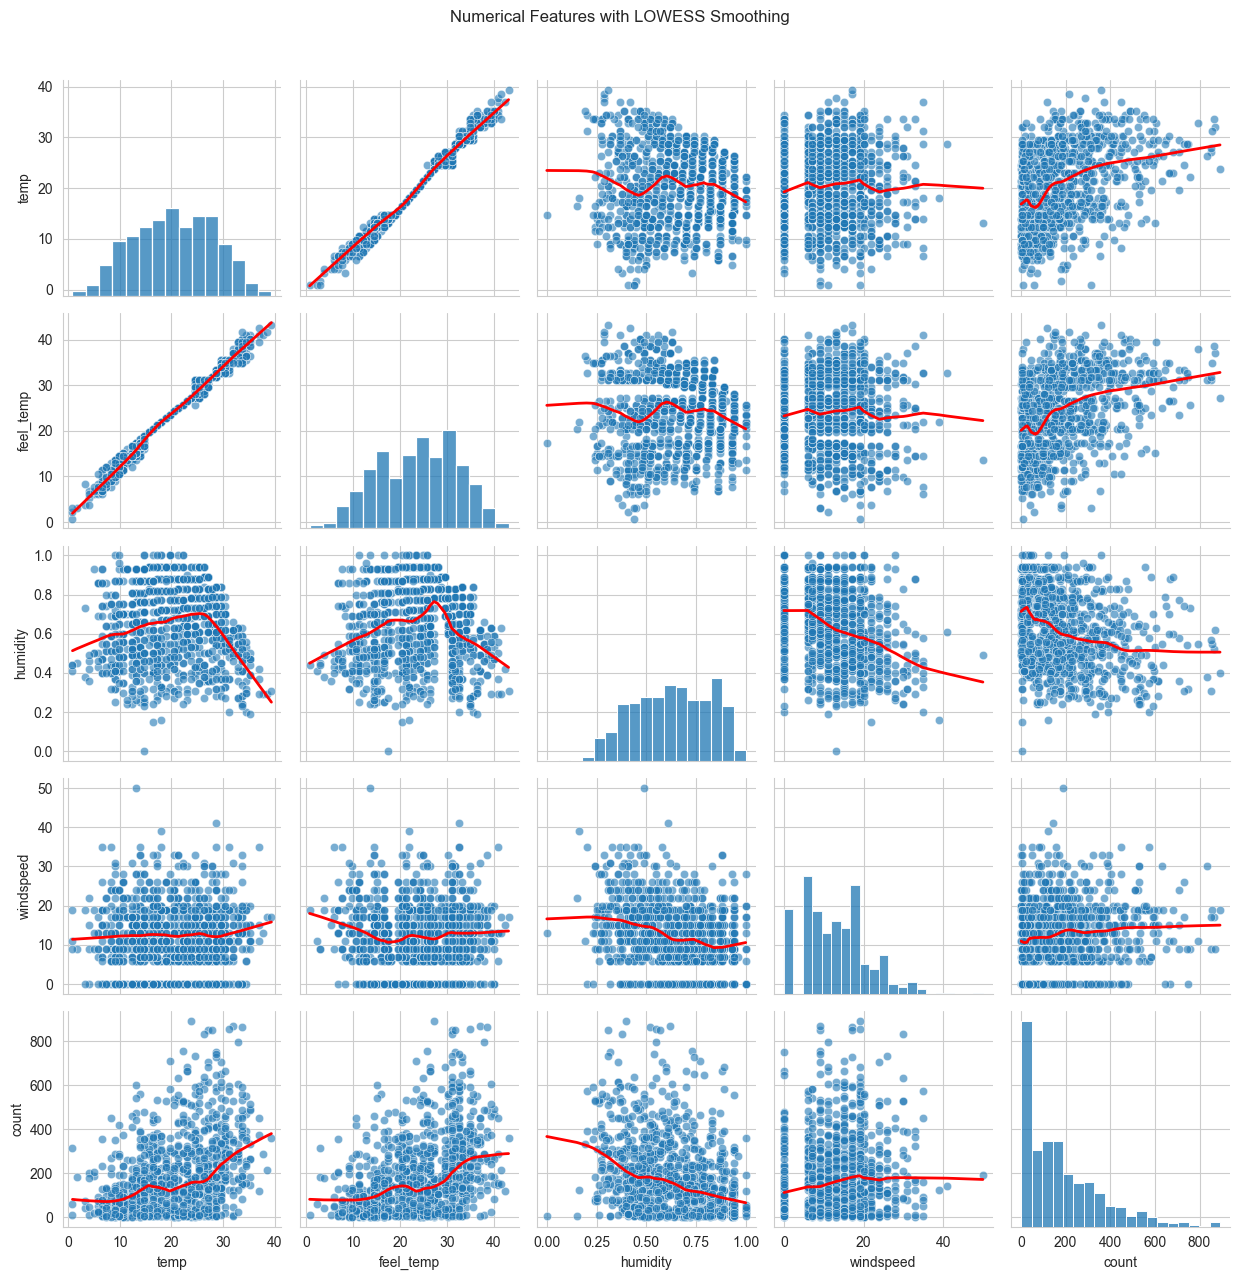

In [77]:
# Visualize key numerical features

numerical_cols = ['temp', 'feel_temp', 'humidity', 'windspeed', 'count']
numerical_cols = [col for col in numerical_cols if col in df.columns]

if len(numerical_cols) > 1:
    # Sample for faster plotting
    plot_df = df[numerical_cols].sample(n=min(1000, len(df)), random_state=42)

    # Create pairplot
    g = sns.pairplot(plot_df, diag_kind='hist', plot_kws={'alpha': 0.6})

    # Add LOWESS smoothing to off-diagonal scatter plots
    for i in range(len(numerical_cols)):
        for j in range(len(numerical_cols)):
            if i != j:  # Only for scatter plots, not diagonal
                ax = g.axes[i, j]
                x_data = plot_df[numerical_cols[j]].values
                y_data = plot_df[numerical_cols[i]].values

                # Remove NaN values for LOWESS
                mask = ~(np.isnan(x_data) | np.isnan(y_data))
                if mask.sum() > 0:
                    x_clean = x_data[mask]
                    y_clean = y_data[mask]

                    # Compute LOWESS smoothing
                    lowess_result = lowess(y_clean, x_clean, frac=0.3)

                    # Plot LOWESS curve
                    ax.plot(lowess_result[:, 0], lowess_result[:, 1],
                           color='red', linewidth=2, label='LOWESS')

    plt.suptitle('Numerical Features with LOWESS Smoothing', y=1.02)
    plt.tight_layout()
    plt.show()

# Continuous Feature Observations
1. **Multicollinearity (temp vs feel_temp)**: Near-perfect linear relationship; drop one, or use ridge to stabilize coefficients (lasso may select one).
2. **Nonlinearity with temperature**: Count increases with temperature but appears to plateau at higher values; fit splines/GAMs or tree-based models to capture this.
3. **Humidity effect**: Clear negative association with count; test an interaction term temp × humidity since hot+humid days look especially low.
4. **Windspeed signal**: Weak/ noisy negative trend; likely a small effect—regularization may shrink it toward zero.
5. **Target distribution**: Count is strongly right-skewed; consider log1p(count) for OLS or a Poisson/negative-binomial GLM.

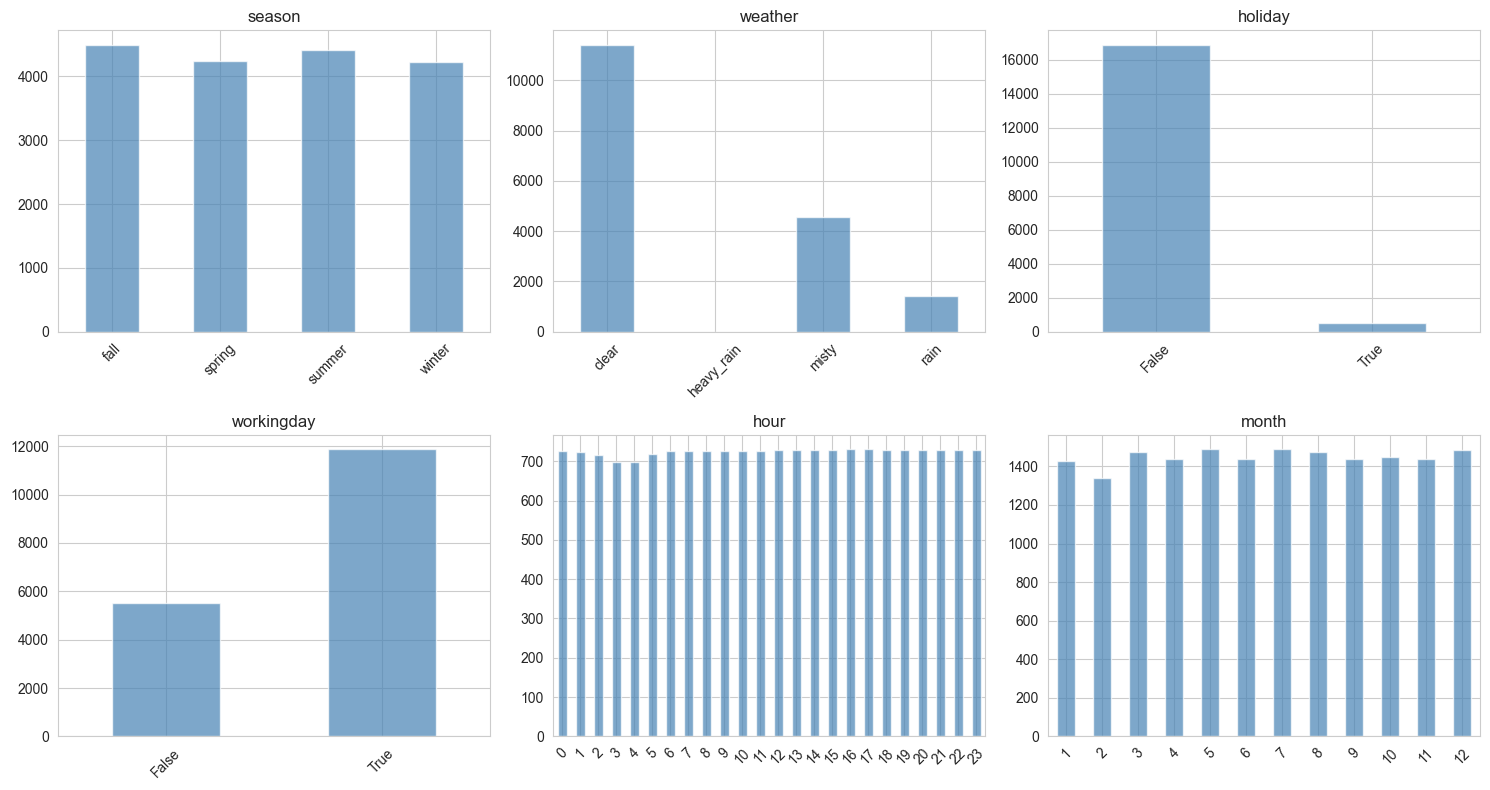

In [78]:
# Visualize categorical features
categorical_cols = ['season', 'weather', 'holiday', 'workingday', 'hour', 'month']
categorical_cols = [col for col in categorical_cols if col in df.columns]

if len(categorical_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for idx, col in enumerate(categorical_cols[:6]):
        df[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='steelblue', alpha=0.7)
        axes[idx].set_title(f'{col}')
        axes[idx].set_xlabel('')
        axes[idx].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for idx in range(len(categorical_cols), 6):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


# Observations:
1. **Season balance**: Roughly even sample counts across seasons; treat season as categorical, and consider interactions with temperature/humidity.
2. **Weather imbalance**: Dominated by clear, with very few rain/heavy_rain; merge rare levels or use class weights to avoid unstable estimates.
3. **Holiday vs workingday redundancy**: holiday=True is a small subset and always workingday=False; keep one or add an interaction, but avoid collinearity.
4. **Hour distribution**: Nearly uniform observations per hour; encode cyclically with sin/cos to capture daily periodicity.
5. **Month distribution**: Close to uniform with slight dips (e.g., February); prefer cyclic encoding or coarser season to reduce sparsity.

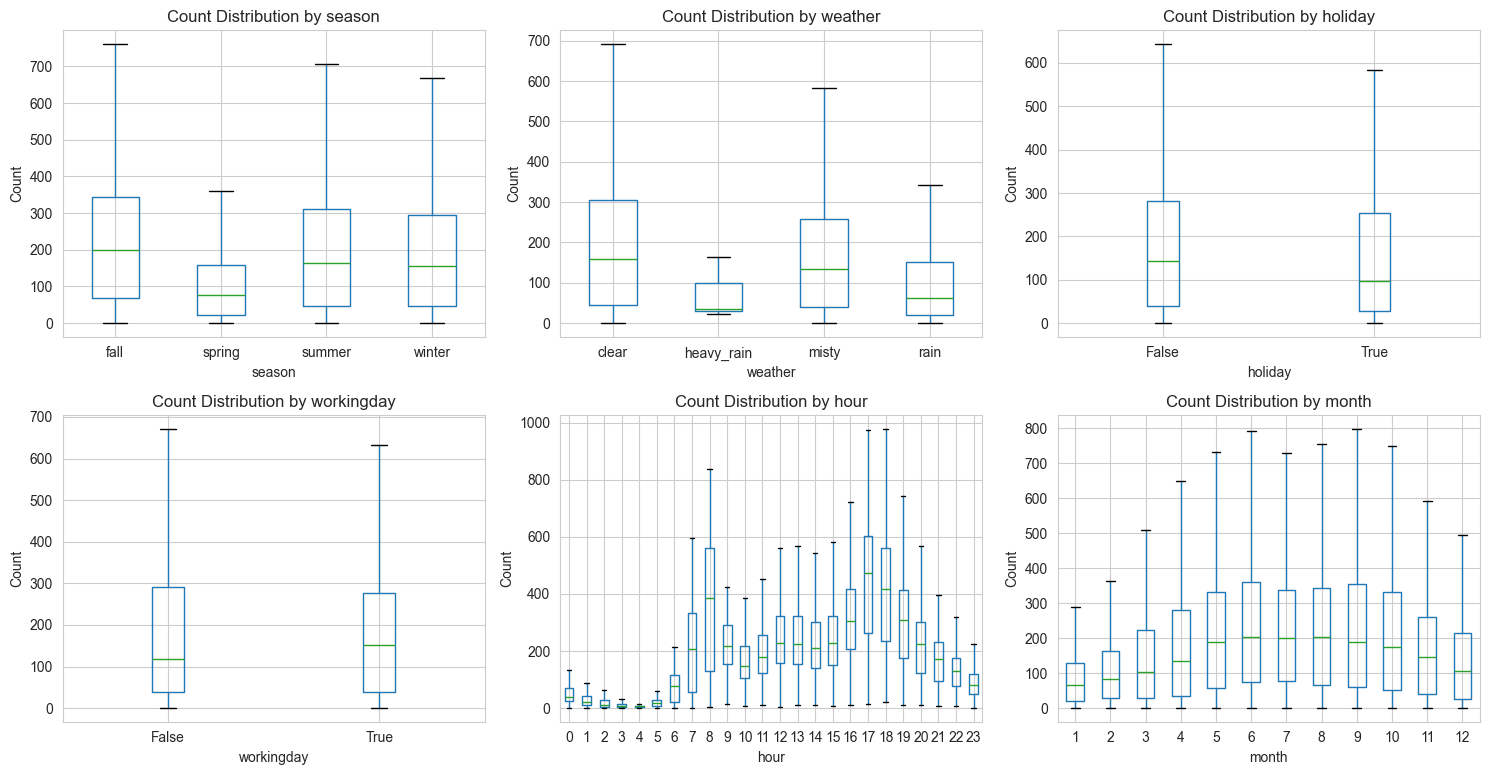

In [79]:
# Visualize target distribution by categorical features
categorical_cols = ['season', 'weather', 'holiday', 'workingday', 'hour', 'month']
categorical_cols = [col for col in categorical_cols if col in df.columns]

if len(categorical_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for idx, col in enumerate(categorical_cols[:6]):
        df.boxplot(column='count', by=col, ax=axes[idx], showfliers=False)
        axes[idx].set_title(f'Count Distribution by {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].get_figure().suptitle('')  # Remove default title

    # Hide unused subplots
    for idx in range(len(categorical_cols), 6):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Observations:
- **Seasonality**: Fall/summer show higher medians and heavier upper tails; spring is lowest → strong seasonal signal.
- **Weather impact**: clear > misty > rain >> heavy_rain; rare heavy_rain has low counts and few samples → consider merging rare levels.
- **Holiday vs workingday**: Holidays have lower counts; they’re largely non-working days → avoid redundancy or model interaction rather than both dummies.
- **Working day pattern**: Higher medians and extremes on working days → commuter-driven demand.
- **Diurnal cycle**: Pronounced peaks around 8 and 17–18, trough at 3–5 → encode hour cyclically (sin/cos) and use time-aware CV.
- **Monthly seasonality**: Mid-summer (7–9) peaks; winter lows (1–2, 12) with varying spread → include month/season features.
- **Outliers/variance**: Long upper whiskers across groups suggest heteroscedasticity and heavy tails → consider log1p(target) or Poisson/NegBin with robust evaluation.
- **Modeling note**: Expect strong interactions (hour×workingday, season×weather); test them and regularize to prevent overfit.

# Time Series Cross-Validation

## Why Standard Cross-Validation Fails for Time Series

In Lecture 6, we used `KFold` cross-validation, which randomly splits data into folds.

**This is incorrect for time series data** because:

1. **Temporal Leakage:** Training on future data to predict the past violates causality. For example, we may randomly sample 2020 data in the training set and 2021 data in the test set!
2. **Unrealistic Performance Estimates:** Random splits inflate metrics because the model "sees" patterns from all time periods
3. **Deployment Mismatch:** In production, you only have past data to predict the future

## Solution: TimeSeriesSplit

`TimeSeriesSplit` respects temporal order by always training on past data and testing on future data.

### Visualization of TimeSeriesSplit (5 folds):

```
Fold 1: [Train---] [Test]
Fold 2: [Train-------] [Test]
Fold 3: [Train-----------] [Test]
Fold 4: [Train---------------] [Test]
Fold 5: [Train-------------------] [Test]
```

**Key properties:**
- Training set grows with each fold (expanding window)
- Test set always comes after training set
- Simulates real-world scenario: use all past data to predict near future


In [80]:
HTML('<iframe src="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html" width="100%" height="500"></iframe>')

Docs iframe skipped (ENABLE_DOC_IFRAMES=False). See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html


In [81]:
# Define X and y from the bike-sharing dataset
# X contains all features except the target variable 'count'
# y is the target variable we want to predict
X = df.drop(columns=['count'])
y = df['count']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Features shape: (17379, 12)
Target shape: (17379,)

Feature columns: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'feel_temp', 'humidity', 'windspeed']


# Define numerical and categorical features

In [82]:
# Demonstrate TimeSeriesSplit + build preprocessing for X
# Use the bike-sharing dataset which has enough samples
# First, let's check we have enough data and define a preprocessing pipeline

print(f"Total samples in dataset: {len(X)}")
print(f"Total samples in target: {len(y)}")

# Identify feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# Common categorical columns in this dataset that can be numeric-coded
categorical_candidates = ['season', 'weather', 'holiday', 'workingday', 'hour', 'month', 'weekday']
categorical_features = [c for c in categorical_candidates if c in X.columns]
# Remove candidate categoricals from numeric list
numeric_features = [c for c in numeric_features if c not in categorical_features]
# Add object/category/bool columns as categoricals
other_cats = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_features = list(dict.fromkeys(categorical_features + other_cats))  # de-duplicate

Total samples in dataset: 17379
Total samples in target: 17379


In [83]:
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['year', 'temp', 'feel_temp', 'humidity', 'windspeed']
Categorical features: ['season', 'weather', 'holiday', 'workingday', 'hour', 'month', 'weekday']


# Define the transformation (imputation and scaling) for numerical features and categorical features
- **Imputation:** Replace missing values with the median for numerical features and the most frequent value for categorical features
- **Scaling:** Standardize numerical features to have mean 0 and variance 1
- **One-hot encoding:** Convert categorical features to a binary matrix of dummy variables

In [84]:
# Define preprocessing pipeline
transformers = [
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ]), categorical_features)
]

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [85]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [86]:
# Perform train-test split (80/20) while preserving time order
# Since this is time series data, we use the first 80% for training and last 20% for testing
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set: {len(X_train)} samples (indices 0 to {split_idx-1})")
print(f"Test set: {len(X_test)} samples (indices {split_idx} to {len(X)-1})")

Training set: 13903 samples (indices 0 to 13902)
Test set: 3476 samples (indices 13903 to 17378)


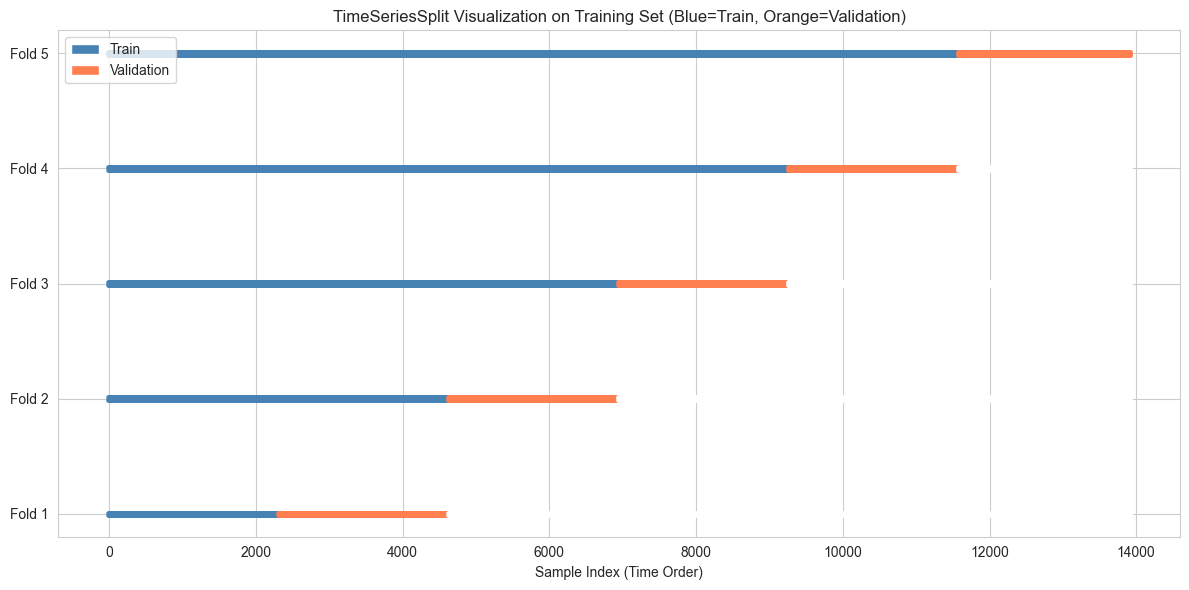


TimeSeriesSplit Statistics (on training set):
Fold 1:
  Train:   2318 samples (indices      0 to   2317)
  Val:     2317 samples (indices   2318 to   4634)
Fold 2:
  Train:   4635 samples (indices      0 to   4634)
  Val:     2317 samples (indices   4635 to   6951)
Fold 3:
  Train:   6952 samples (indices      0 to   6951)
  Val:     2317 samples (indices   6952 to   9268)
Fold 4:
  Train:   9269 samples (indices      0 to   9268)
  Val:     2317 samples (indices   9269 to  11585)
Fold 5:
  Train:  11586 samples (indices      0 to  11585)
  Val:     2317 samples (indices  11586 to  13902)


In [87]:
# Use fewer splits to ensure we have enough samples
# TimeSeriesSplit requires at least n_splits + 1 samples
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits (based on time order of X_train)
fig, ax = plt.subplots(figsize=(12, 6))

n_samples = len(X_train)
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    # Create binary mask
    mask = np.zeros(n_samples)
    mask[train_idx] = 1  # Training
    mask[val_idx] = 2    # Validation

    # Plot
    colors = ['white', 'steelblue', 'coral']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    ax.scatter(range(n_samples), [i] * n_samples, c=mask, cmap=cmap,
               marker='s', s=10, vmin=0, vmax=2)

ax.set_yticks(range(5))
ax.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax.set_xlabel('Sample Index (Time Order)')
ax.set_title('TimeSeriesSplit Visualization on Training Set (Blue=Train, Orange=Validation)')

# Add legend
legend_elements = [Patch(facecolor='steelblue', label='Train'),
                   Patch(facecolor='coral', label='Validation')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# Print statistics for each fold
print("\nTimeSeriesSplit Statistics (on training set):")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx):6d} samples (indices {train_idx[0]:6d} to {train_idx[-1]:6d})")
    print(f"  Val:   {len(val_idx):6d} samples (indices {val_idx[0]:6d} to {val_idx[-1]:6d})")


# Modeling Count Data: Poisson Regression

## Why Not Use Linear Regression for Counts? (but we will try it anyway)

Our target variable `count` is a **non-negative integer** (0, 1, 2, ...). Standard linear regression has problems:

1. **Can predict negative values** — nonsensical for counts
2. **Assumes constant variance** — count data typically has variance proportional to mean
3. **Wrong error distribution** — counts follow Poisson/negative binomial, not Gaussian

## Poisson Distribution

The Poisson distribution models the number of events occurring in a fixed interval:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \ldots
$$

where $\lambda > 0$ is both the mean and variance.

**Key property:** $E[Y] = \text{Var}(Y) = \lambda$

## Poisson Regression

Model the mean count as:
$$
\log(\lambda) = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p
$$

Equivalently:
$$
\lambda = \exp(\beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p)
$$

**Benefits:**
- Always predicts non-negative values (exp > 0)
- Captures multiplicative effects (e.g., doubling temperature scales demand by a factor)
- Appropriate likelihood function (Poisson deviance loss)


In [88]:
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


In [89]:
# # Preprocessing for LINEAR models (Ridge, Poisson)
# # - Standardize numerical features
# # - One-hot encode categorical features

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("numerical_feature_preprocessor", StandardScaler(), continous_features),
#         ("categorical_feature_preprocessor", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
#     ]
# )

# print("Linear Model Preprocessor:")
# print(f"  Numerical features ({len(continous_features)}): StandardScaler")
# print(f"  Categorical features ({len(categorical_features)}): OneHotEncoder")
# preprocessor

## Building Complete Pipelines

Now we combine preprocessing with models into end-to-end pipelines.

**Models to compare:**
1. **Ridge Regression** — Linear model with L2 regularization
2. **Poisson Regression** — Generalized linear model for count data

In [90]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [91]:
# 1. Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

# 2. Poisson Regression Pipeline
poisson_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", PoissonRegressor(alpha=1.0, max_iter=1000))
])

# Evaluation Metrics for Regression

We'll use multiple metrics to get a comprehensive view:

### RMSE (Root Mean Squared Error)
$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$
- **Units:** Same as target (bike counts)
- **Interpretation:** Average prediction error; penalizes large errors heavily
- **Lower is better**

### MAE (Mean Absolute Error)
$$
\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
$$
- **Units:** Same as target
- **Interpretation:** Average absolute deviation; less sensitive to outliers than RMSE
- **Lower is better**

### R² Score (Coefficient of Determination)
$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$
- **Units:** Dimensionless (0 to 1, can be negative for poor models)
- **Interpretation:** Fraction of variance explained by the model
- **Higher is better** (1.0 = perfect predictions, 0.0 = as good as predicting the mean)

In [92]:
# Train and evaluate Ridge and Poisson Regression pipelines

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define scoring metrics
scoring = {
    'neg_rmse': 'neg_root_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Perform cross-validation for Ridge Regression
ridge_cv_results = cross_validate(
    ridge_pipeline,
    X_train,
    y_train,
    cv=tscv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Perform cross-validation for Poisson Regression
poisson_cv_results = cross_validate(
    poisson_pipeline,
    X_train,
    y_train,
    cv=tscv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Prepare comparison data with mean ± std format
comparison_data = [
    {
        'Model': 'Ridge Regression',
        'RMSE': f"{-ridge_cv_results['test_neg_rmse'].mean():.2f} ± {ridge_cv_results['test_neg_rmse'].std():.2f}",
        'MAE': f"{-ridge_cv_results['test_neg_mae'].mean():.2f} ± {ridge_cv_results['test_neg_mae'].std():.2f}",
        'R²': f"{ridge_cv_results['test_r2'].mean():.3f} ± {ridge_cv_results['test_r2'].std():.3f}"
    },
    {
        'Model': 'Poisson Regression',
        'RMSE': f"{-poisson_cv_results['test_neg_rmse'].mean():.2f} ± {poisson_cv_results['test_neg_rmse'].std():.2f}",
        'MAE': f"{-poisson_cv_results['test_neg_mae'].mean():.2f} ± {poisson_cv_results['test_neg_mae'].std():.2f}",
        'R²': f"{poisson_cv_results['test_r2'].mean():.3f} ± {poisson_cv_results['test_r2'].std():.3f}"
    }
]

# Create and display comparison table
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Model,RMSE,MAE,R²
0,Ridge Regression,108.83 ± 19.42,80.58 ± 16.53,0.545 ± 0.092
1,Poisson Regression,108.75 ± 26.12,78.68 ± 20.10,0.552 ± 0.083


# Gradient Boosting: A Powerful Ensemble Method

## What is Gradient Boosting?

**Core Idea:** Build an ensemble of weak learners (typically decision trees) sequentially, where each new tree corrects errors made by the previous ensemble.

### How it Works (Simplified):

1. **Start with a simple prediction** (e.g., mean of target)
2. **Compute residuals** (errors) from current predictions
3. **Train a new tree to predict the residuals**
4. **Add this tree to the ensemble** (with a learning rate to control contribution)
5. **Repeat** steps 2-4 for many iterations

Mathematically, for regression:
$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$

where:
- $F_m(x)$ is the ensemble after $m$ trees
- $h_m(x)$ is the new tree predicting residuals
- $\nu$ is the learning rate (shrinkage parameter)

## HistGradientBoostingRegressor

Scikit-learn's `HistGradientBoostingRegressor` is an efficient implementation inspired by LightGBM:

**Key Features:**
- **Histogram-based:** Bins continuous features → faster training
- **Native categorical support:** Can handle categorical variables directly
- **Multiple loss functions:** Including Poisson for count data
- **Scalable:** Handles large datasets efficiently

**Important Hyperparameters:**
- `max_iter`: Number of boosting iterations (trees)
- `learning_rate`: Shrinkage factor (typically 0.01-0.3)
- `max_depth`: Maximum depth of each tree
- `loss`: Loss function (`"squared_error"`, `"poisson"`, `"absolute_error"`, etc.)


In [93]:
# 3. Histogram-Based Gradient Boosting Pipeline (with Poisson loss)
hgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", HistGradientBoostingRegressor(
        loss="poisson",
        max_iter=100,
        random_state=RANDOM_STATE
    ))
])

# Fit and evaluate the Histogram-Based Gradient Boosting model
hgb_pipeline.fit(X_train, y_train)
hgb_scores = cross_val_score(
    hgb_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
hgb_mae_scores = cross_val_score(
    hgb_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
hgb_r2_scores = cross_val_score(
    hgb_pipeline, X_train, y_train,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

# Add HistGradientBoosting results to comparison table
comparison_data.append({
    "Model": "HistGradientBoosting",
    "RMSE": f"{-hgb_scores.mean():.2f} ± {hgb_scores.std():.2f}",
    "MAE": f"{-hgb_mae_scores.mean():.2f} ± {hgb_mae_scores.std():.2f}",
    "R²": f"{hgb_r2_scores.mean():.3f} ± {hgb_r2_scores.std():.3f}"
})

# Display updated comparison table
pd.DataFrame(comparison_data)

,Model,RMSE,MAE,R²
0,Ridge Regression,108.83 ± 19.42,80.58 ± 16.53,0.545 ± 0.092
1,Poisson Regression,108.75 ± 26.12,78.68 ± 20.10,0.552 ± 0.083
2,HistGradientBoosting,75.06 ± 17.17,49.17 ± 11.04,0.758 ± 0.117


## Additional Models Included

- Random Forest: Bagging of decision trees; robust, handles nonlinearity, less tuning than boosting.
- MLP (Neural Network): Flexible function approximator; captures complex interactions; sensitive to scaling and hyperparameters.
- k-Nearest Neighbors: Instance-based; simple and competitive on well-scaled data; can be slower on large datasets.

We include these alongside Ridge, Poisson, and HistGradientBoosting to compare linear, count-aware GLM, boosted trees, bagged trees, neural nets, and instance-based methods under the same time-series CV protocol.


In [94]:
# 4. Random Forest Pipeline (tree-based, bagging)
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Fit and evaluate the Random Forest model
rf_pipeline.fit(X_train, y_train)
rf_scores = cross_val_score(
    rf_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
rf_mae_scores = cross_val_score(
    rf_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
rf_r2_scores = cross_val_score(
    rf_pipeline, X_train, y_train,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

# Add Random Forest results to comparison table
comparison_data.append({
    "Model": "Random Forest",
    "RMSE": f"{-rf_scores.mean():.2f} ± {rf_scores.std():.2f}",
    "MAE": f"{-rf_mae_scores.mean():.2f} ± {rf_mae_scores.std():.2f}",
    "R²": f"{rf_r2_scores.mean():.3f} ± {rf_r2_scores.std():.3f}"
})

# 5. Multi-Layer Perceptron (Neural Network) Pipeline
mlp_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        alpha=1e-4,
        max_iter=300,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])

# Fit and evaluate the MLP model
mlp_pipeline.fit(X_train, y_train)
mlp_scores = cross_val_score(
    mlp_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
mlp_mae_scores = cross_val_score(
    mlp_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
mlp_r2_scores = cross_val_score(
    mlp_pipeline, X_train, y_train,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

# Add MLP results to comparison table
comparison_data.append({
    "Model": "MLP (Neural Network)",
    "RMSE": f"{-mlp_scores.mean():.2f} ± {mlp_scores.std():.2f}",
    "MAE": f"{-mlp_mae_scores.mean():.2f} ± {mlp_mae_scores.std():.2f}",
    "R²": f"{mlp_r2_scores.mean():.3f} ± {mlp_r2_scores.std():.3f}"
})

# 6. k-Nearest Neighbors Pipeline
knn_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsRegressor(
        n_neighbors=20,
        weights="distance"
    ))
])

# Fit and evaluate the k-NN model
knn_pipeline.fit(X_train, y_train)
knn_scores = cross_val_score(
    knn_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
knn_mae_scores = cross_val_score(
    knn_pipeline, X_train, y_train,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
knn_r2_scores = cross_val_score(
    knn_pipeline, X_train, y_train,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

# Add k-NN results to comparison table
comparison_data.append({
    "Model": "k-Nearest Neighbors",
    "RMSE": f"{-knn_scores.mean():.2f} ± {knn_scores.std():.2f}",
    "MAE": f"{-knn_mae_scores.mean():.2f} ± {knn_mae_scores.std():.2f}",
    "R²": f"{knn_r2_scores.mean():.3f} ± {knn_r2_scores.std():.3f}"
})

In [95]:
pd.DataFrame(comparison_data)

,Model,RMSE,MAE,R²
0,Ridge Regression,108.83 ± 19.42,80.58 ± 16.53,0.545 ± 0.092
1,Poisson Regression,108.75 ± 26.12,78.68 ± 20.10,0.552 ± 0.083
2,HistGradientBoosting,75.06 ± 17.17,49.17 ± 11.04,0.758 ± 0.117
3,Random Forest,88.86 ± 20.11,61.53 ± 17.76,0.667 ± 0.158
4,MLP (Neural Network),70.93 ± 5.70,50.01 ± 4.45,0.790 ± 0.076
5,k-Nearest Neighbors,132.83 ± 27.54,100.31 ± 22.89,0.330 ± 0.133


In [96]:
HTML('<iframe src="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html" width="100%" height="500"></iframe>')

Docs iframe skipped (ENABLE_DOC_IFRAMES=False). See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html


# Model Comparison with Cross-Validation

Now we'll evaluate the selected models using `cross_validate` with `TimeSeriesSplit` (see toggles above).


In [97]:
# Define scoring metrics
scoring = {
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2",
}

# Define cross-validation strategy
cv = TimeSeriesSplit(n_splits=5)

# Store results
results = {}

# All models (filtered by ENABLED_MODELS)
all_models = {
    "Ridge": ridge_pipeline,
    "PoissonReg": poisson_pipeline,
    "HistGBR": hgb_pipeline,
    "RandomForest": rf_pipeline,
    "MLP": mlp_pipeline,
    "KNN": knn_pipeline,
}
models = {name: all_models[name] for name in ENABLED_MODELS if name in all_models}

print("Starting cross-validation for selected models...\n")
print(f"Models: {list(models.keys())}")

for model_name, pipeline in models.items():
    print(f"Evaluating {model_name}...")
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    results[model_name] = cv_results
    print(f"  ✓ Complete")

print("\n✓ All models evaluated!")

# Process results into a summary table
summary = []

for model_name, cv_res in results.items():
    row = {"Model": model_name}

    # For negative scores, flip sign for display
    for metric_name in scoring.keys():
        scores = cv_res[f"test_{metric_name}"]

        # Flip sign for "neg_*" metrics
        if metric_name in ["RMSE", "MAE"]:
            scores = -scores

        row[f"{metric_name} (mean)"] = scores.mean()
        row[f"{metric_name} (std)"] = scores.std()

    summary.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary)

# Display with nice formatting
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Hyperparameter tuning for top models
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grids for each model
# Define parameter grids for hyperparameter tuning
# Each grid explores key hyperparameters that significantly impact model performance
param_grids = {
    "Ridge": {
        "model__alpha": [0.1, 1.0, 10.0, 100.0]  # Regularization strength
    },
    "PoissonReg": {
        "model__alpha": [0.1, 1.0, 10.0],  # Regularization strength
        "model__max_iter": [100, 300, 500]  # Maximum iterations for convergence
    },
    "HistGBR": {
        "model__max_depth": [3, 5, 7, None],  # Tree depth (None = unlimited)
        "model__learning_rate": [0.05, 0.1, 0.2],  # Step size for gradient descent
        "model__max_iter": [100, 200],  # Number of boosting iterations
        "model__min_samples_leaf": [20, 50]  # Minimum samples per leaf
    },
    "RandomForest": {
        "model__n_estimators": [100, 200],  # Number of trees
        "model__max_depth": [10, 20, None],  # Maximum tree depth
        "model__min_samples_split": [2, 5],  # Minimum samples to split node
        "model__min_samples_leaf": [1, 2],  # Minimum samples per leaf
        "model__max_features": ["sqrt", None]  # Features to consider for splits
    },
    "MLP": {
        "model__hidden_layer_sizes": [(50,), (100,), (100, 50)],  # Network architecture
        "model__alpha": [0.0001, 0.001, 0.01],  # L2 regularization
        "model__learning_rate_init": [0.001, 0.01],  # Initial learning rate
        "model__max_iter": [200, 500]  # Maximum training iterations
    },
    "KNN": {
        "model__n_neighbors": [5, 7, 10, 15],  # Number of neighbors
        "model__weights": ["uniform", "distance"],  # Weighting scheme
        "model__metric": ["euclidean", "manhattan"]  # Distance metric
    }
}

# Perform grid search for all models
tuning_results = {}

for model_name in models.keys():
    if model_name in param_grids:
        print(f"\nTuning {model_name}...")

        grid_search = GridSearchCV(
            models[model_name],
            param_grids[model_name],
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X, y)

        tuning_results[model_name] = {
            "best_params": grid_search.best_params_,
            "best_score": -grid_search.best_score_,
            "improvement": summary_df[summary_df['Model'] == model_name]['RMSE (mean)'].values[0] - (-grid_search.best_score_)
        }

        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best RMSE: {-grid_search.best_score_:.2f}")
        print(f"  Improvement: {tuning_results[model_name]['improvement']:.2f}")
        print(f"  ✓ Complete")
    else:
        print(f"\nSkipping {model_name} (no parameter grid defined)")

# Display tuning summary
print("\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)

tuning_summary = []
for model_name, result in tuning_results.items():
    tuning_summary.append({
        "Model": model_name,
        "Best RMSE": f"{result['best_score']:.2f}",
        "Improvement": f"{result['improvement']:.2f}",
        "Best Parameters": str(result['best_params'])
    })

tuning_df = pd.DataFrame(tuning_summary)
print(tuning_df.to_string(index=False))
print("="*80)

Starting cross-validation for selected models...

Models: ['Ridge', 'PoissonReg', 'HistGBR', 'RandomForest', 'MLP', 'KNN']
Evaluating Ridge...
  ✓ Complete
Evaluating PoissonReg...
  ✓ Complete
Evaluating HistGBR...
  ✓ Complete
Evaluating RandomForest...
  ✓ Complete
Evaluating MLP...
  ✓ Complete
Evaluating KNN...
  ✓ Complete

✓ All models evaluated!

CROSS-VALIDATION RESULTS SUMMARY
       Model  RMSE (mean)  RMSE (std)  MAE (mean)  MAE (std)  R2 (mean)  R2 (std)
       Ridge   116.580778   20.838442   86.578848  16.957780   0.573350  0.054084
  PoissonReg   115.001973   21.742917   82.521178  16.808124   0.579651  0.074071
     HistGBR    79.619045   18.780439   52.545974  13.023413   0.777869  0.114509
RandomForest    88.970977   17.046042   62.216868  13.099398   0.716466  0.134325
         MLP    81.898025   11.183522   59.348940   8.014536   0.761504  0.103793
         KNN   145.390748   30.080224  107.456341  21.473587   0.307613  0.254832

HYPERPARAMETER TUNING

Tuning Ridge

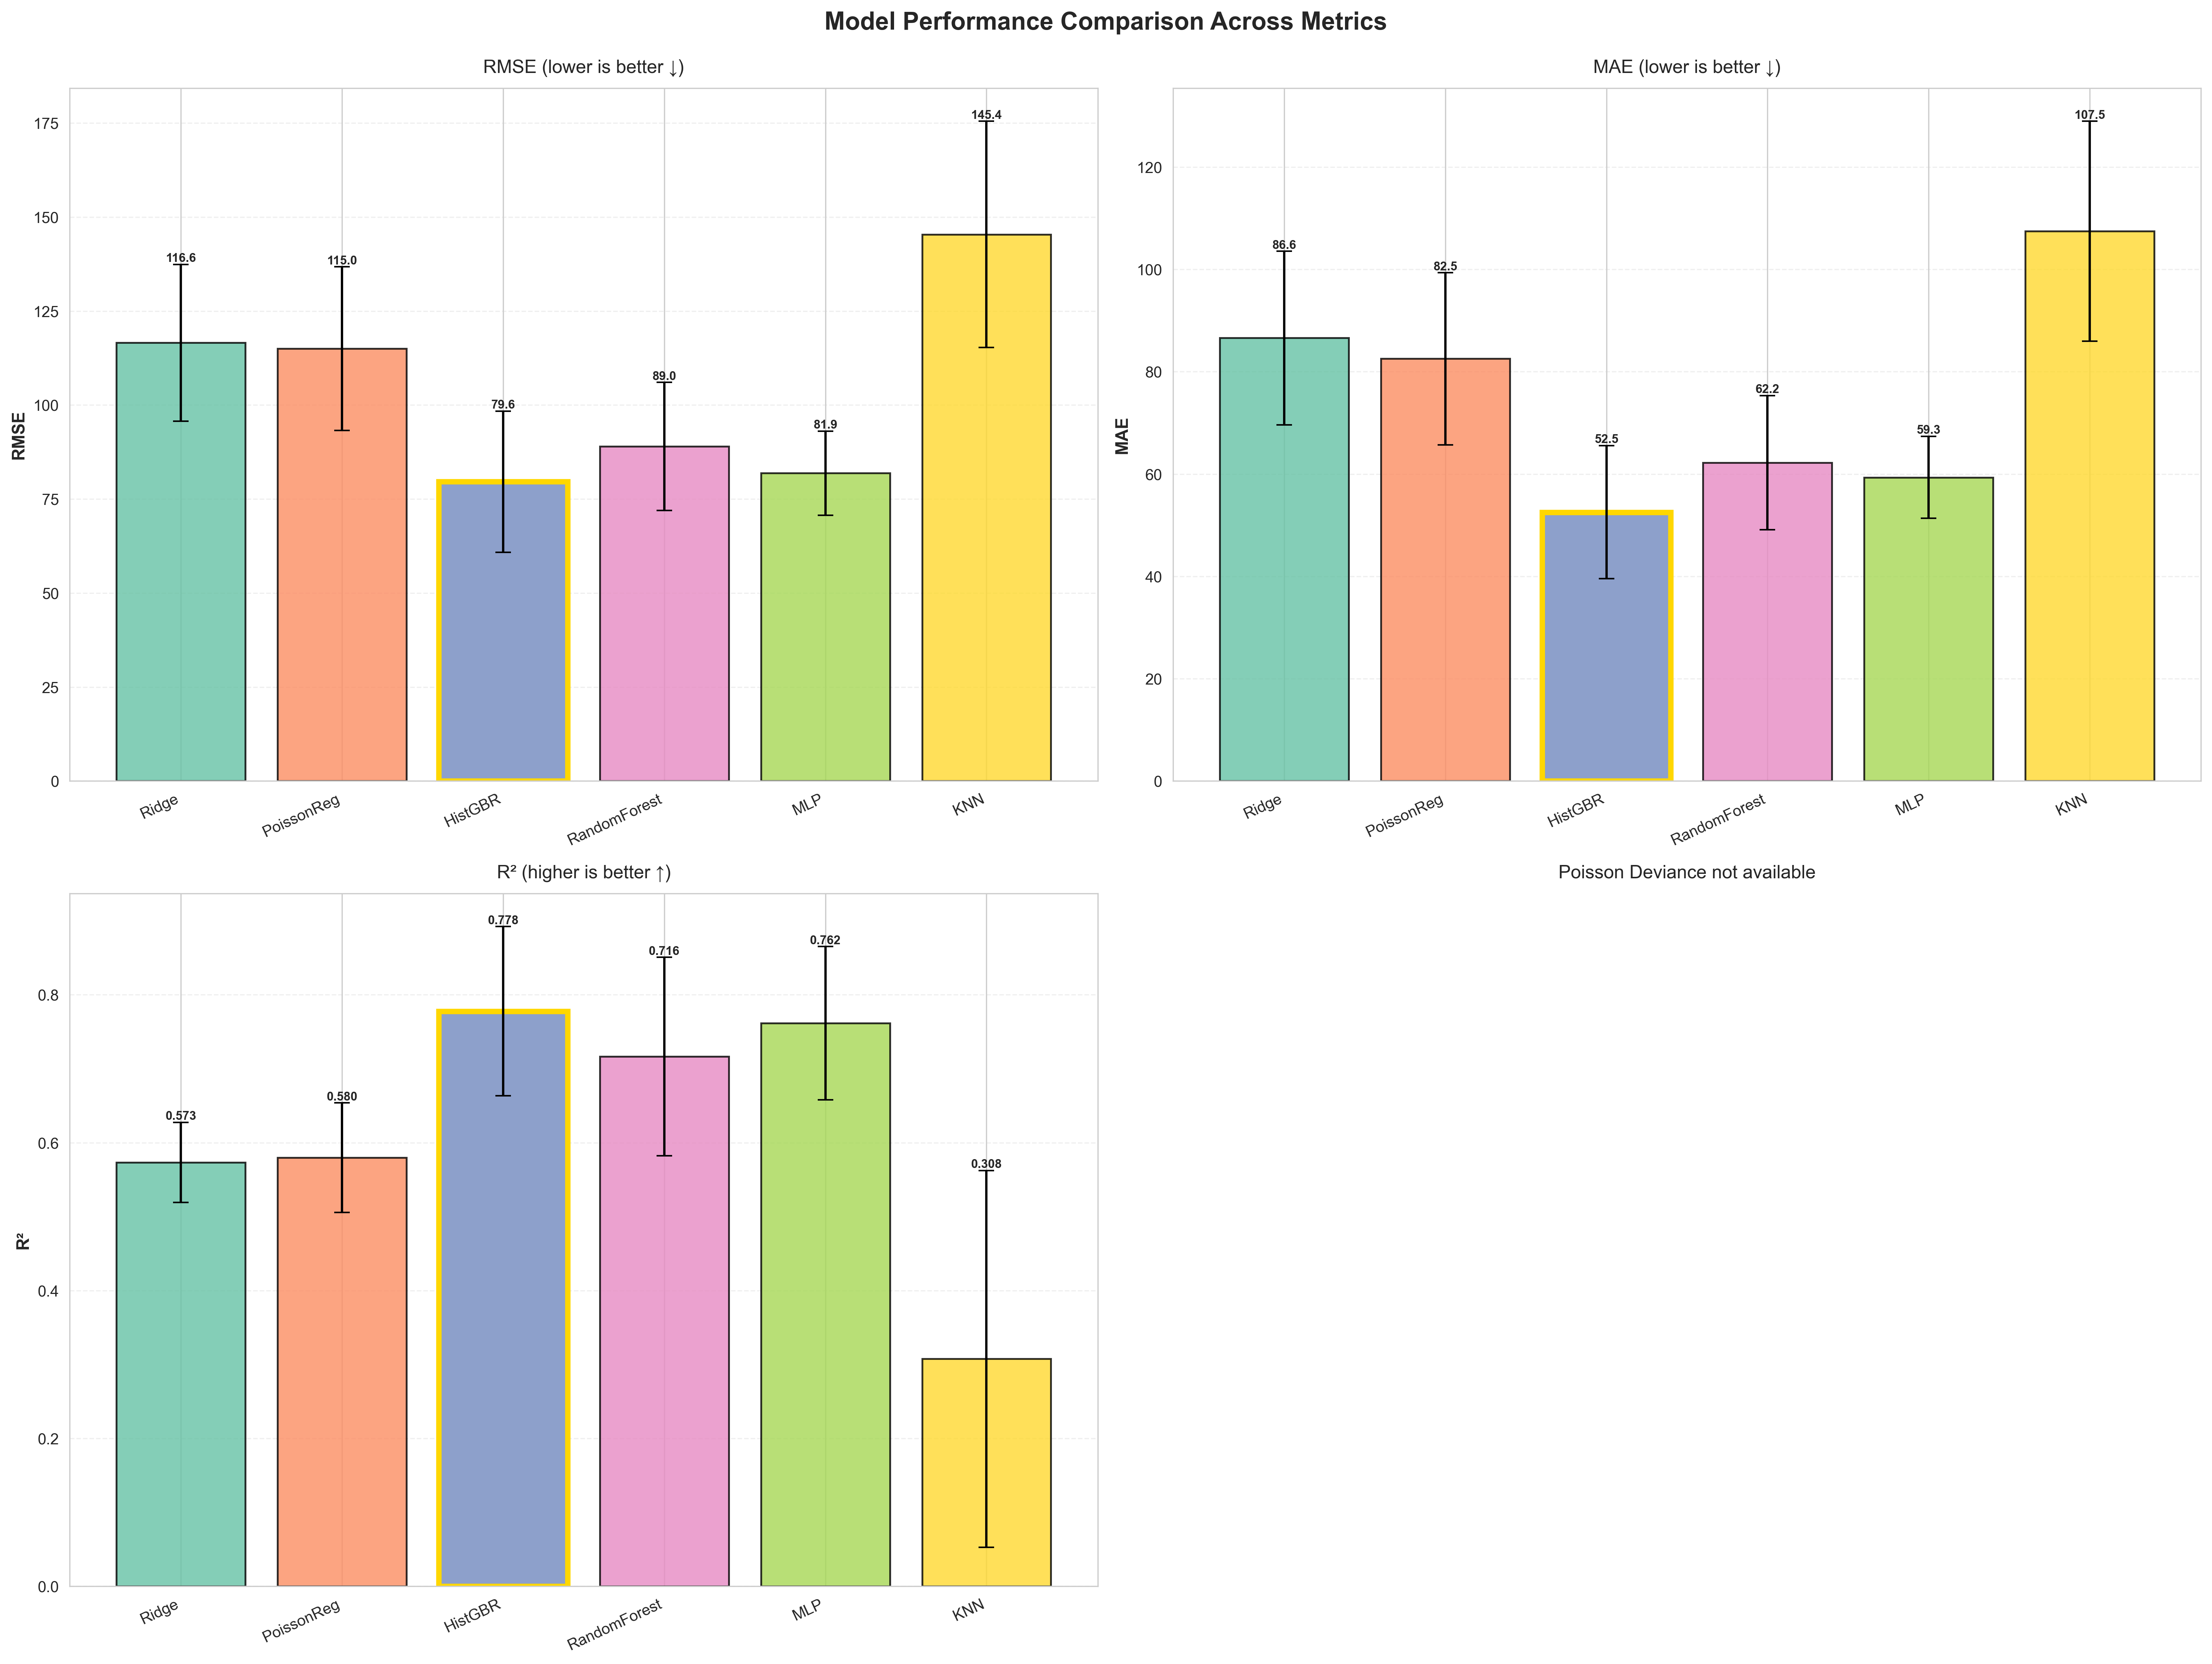

In [98]:
# Visualize model comparison across all metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 15), dpi=300)
fig.suptitle('Model Performance Comparison Across Metrics', fontsize=16, fontweight='bold', y=0.995)

metrics_to_plot = ["RMSE", "MAE", "R²", "Poisson Deviance"]
metric_key_map = {"R²": "R2", "RMSE": "RMSE", "MAE": "MAE", "Poisson Deviance": "Poisson Deviance"}
model_order = list(models.keys())
colors = sns.color_palette("Set2", n_colors=len(model_order))

for idx, metric_display in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]

    # Extract means and standard deviations from summary_df
    # The column names in summary_df are formatted as "RMSE (mean)", "MAE (mean)", etc.
    means = []
    stds = []

    base_key = metric_key_map.get(metric_display, metric_display)
    metric_col = f"{base_key} (mean)"
    if metric_col not in summary_df.columns:
        ax.axis('off')
        ax.set_title(f'{metric_display} not available', fontsize=12, pad=10)
        continue

    for model in model_order:
        model_row = summary_df[summary_df['Model'] == model]
        value = model_row[metric_col].values[0]
        # Support both string "mean ± std" and numeric mean with separate std column
        if isinstance(value, str) and '±' in value:
            mean_val_str, std_val_str = value.split(' ± ')
            mean_val = float(mean_val_str)
            std_val = float(std_val_str)
        else:
            mean_val = float(value)
            std_col = f"{base_key} (std)"
            std_val = float(model_row[std_col].values[0]) if std_col in summary_df.columns else 0.0
        means.append(mean_val)
        stds.append(std_val)

    # Create bar chart
    x_pos = np.arange(len(model_order))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8,
                   color=colors, edgecolor='black', linewidth=1.2)

    # Formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_order, rotation=25, ha='right', fontsize=10)
    ax.set_ylabel(metric_display, fontsize=11, fontweight='bold')

    # Set title with direction indicator
    if metric_display == "R²":
        title = f'{metric_display} (higher is better ↑)'
        best_idx = np.argmax(means)
    else:
        title = f'{metric_display} (lower is better ↓)'
        best_idx = np.argmin(means)

    ax.set_title(title, fontsize=12, pad=10)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Highlight best performing model
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3.5)
    bars[best_idx].set_alpha(1.0)

    # Add value labels on top of bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        label = f'{mean:.1f}' if metric_display != "R²" else f'{mean:.3f}'
        ax.text(i, mean + std, label, ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


# Feature Importance per Model

We visualize which features matter for each selected model:
- Linear models (Ridge, Poisson): coefficient magnitudes (sign shows direction)
- Tree ensembles (HistGBR, RandomForest): impurity-based feature_importances_
- Others (MLP, KNN): permutation importance on the transformed feature space

To keep class runtime manageable, we use smaller samples and repeats when FAST_MODE is on.



Fitting Ridge on training data for importance analysis...


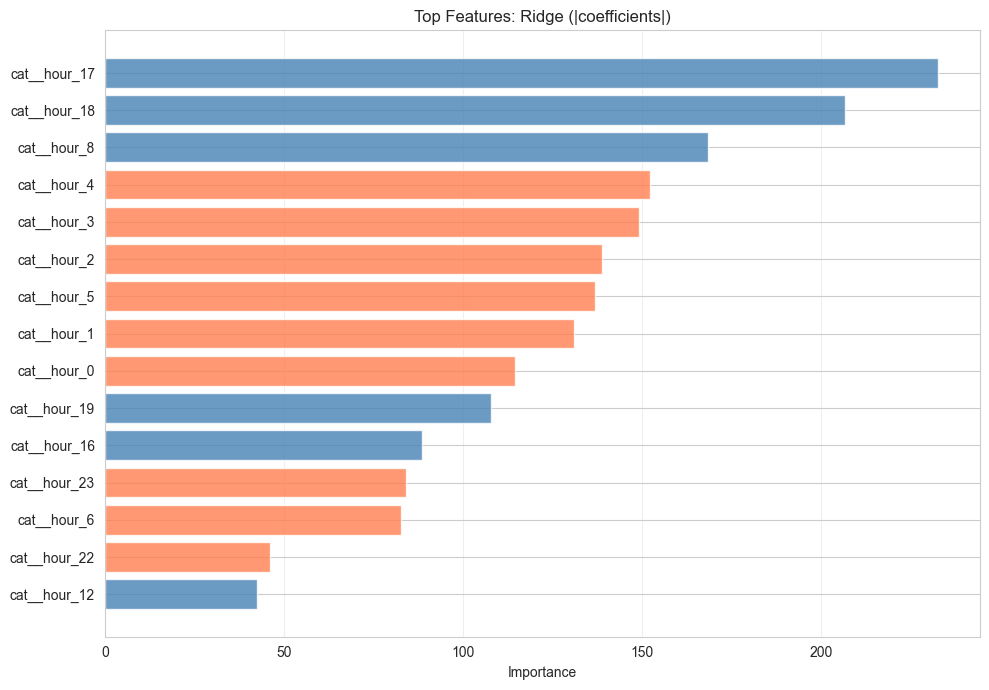


Fitting PoissonReg on training data for importance analysis...


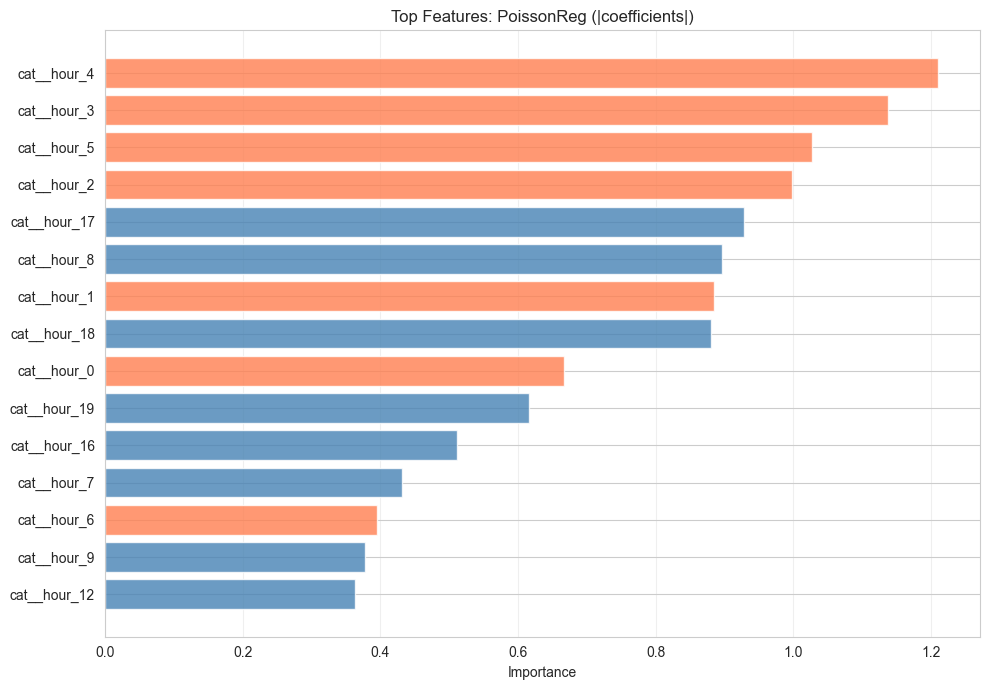


Fitting HistGBR on training data for importance analysis...


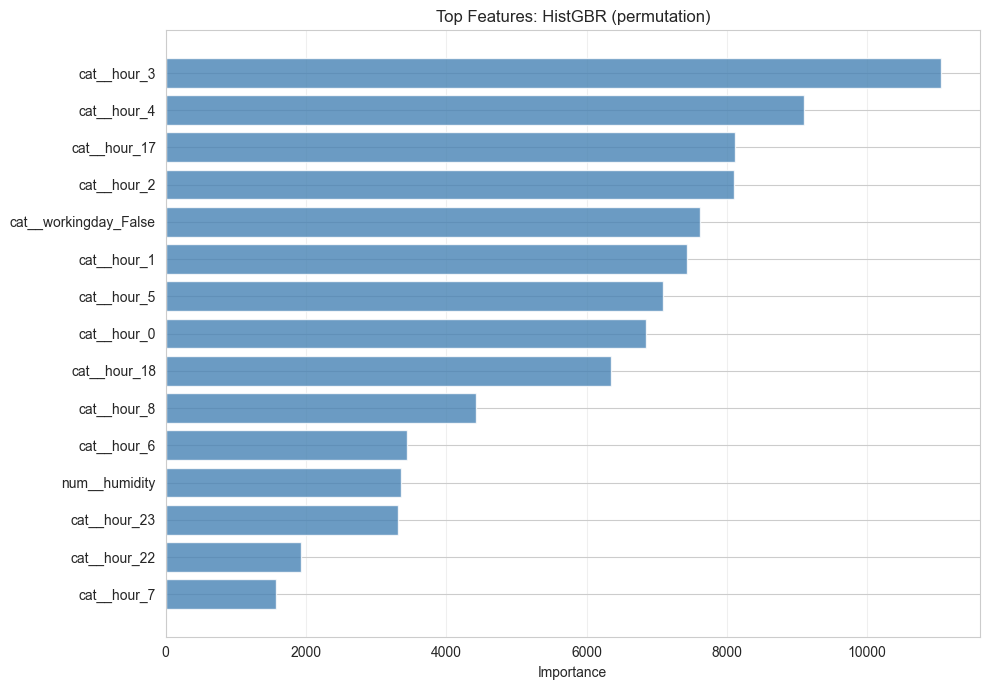


Fitting RandomForest on training data for importance analysis...


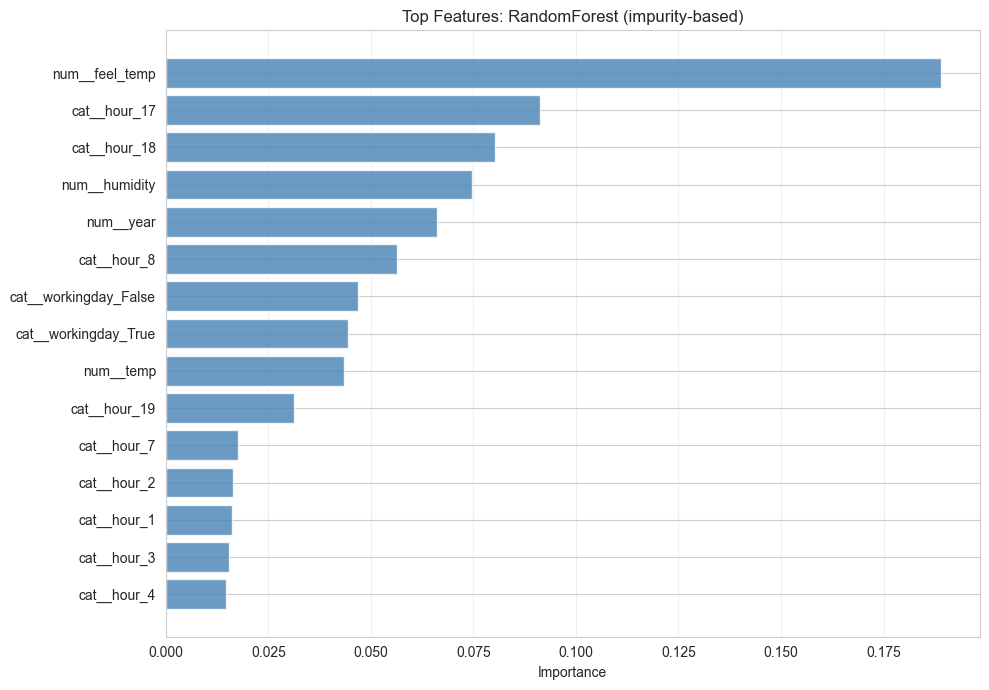


Fitting MLP on training data for importance analysis...


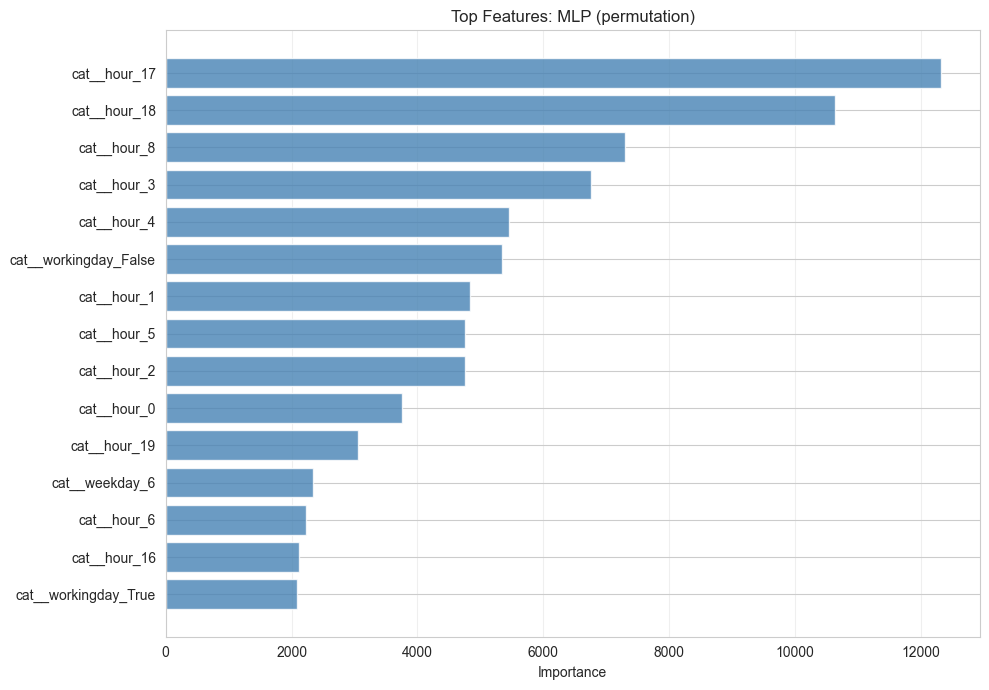


Fitting KNN on training data for importance analysis...


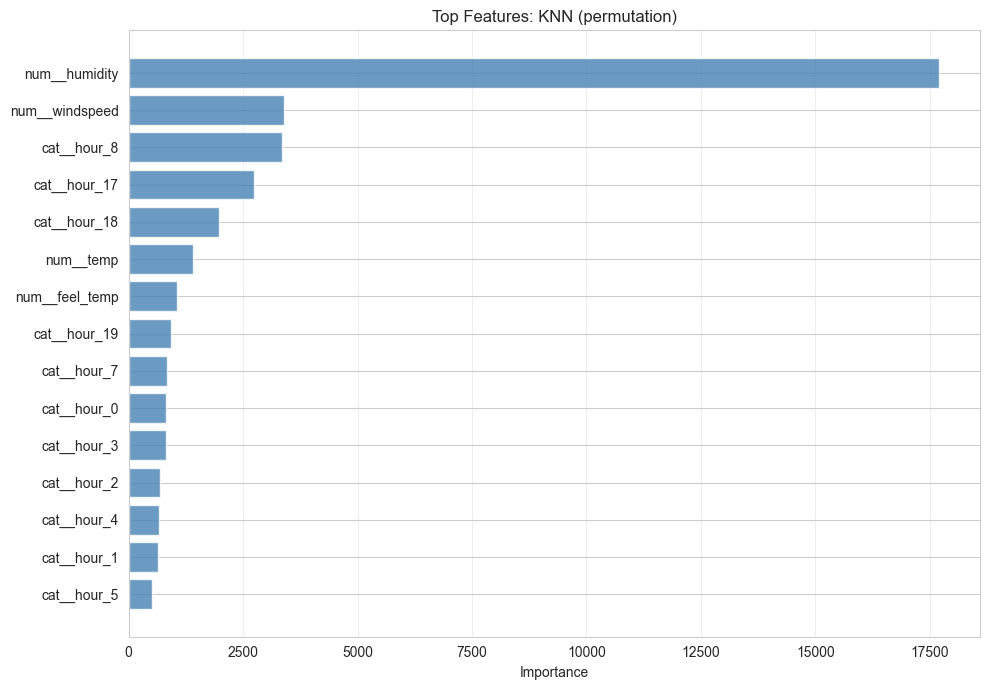

In [99]:
# Compute and plot feature importances for each selected model

def _get_feature_names(preprocessor, n_fallback):
    try:
        names = preprocessor.get_feature_names_out()
    except Exception:
        names = [f"feature_{i}" for i in range(n_fallback)]
    return np.array(names)

def _plot_top_features(names, values, title, top_n=15, signs=None):
    order = np.argsort(values)[::-1][:top_n]
    plt.figure(figsize=(10, max(5, int(top_n * 0.5))))
    colors = ['steelblue'] * len(order)
    if signs is not None:
        colors = [('coral' if signs[i] < 0 else 'steelblue') for i in order]
    plt.barh(range(len(order)), values[order][::-1], color=colors[::-1], alpha=0.8)
    plt.yticks(range(len(order)), names[order][::-1])
    plt.xlabel('Importance')
    plt.title(title)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Use selected models from earlier (models dict) and fit them on training data
models_to_explain = models

for model_name, pipe in models_to_explain.items():
    print(f"\nFitting {model_name} on training data for importance analysis...")
    pipe.fit(X_train, y_train)

    preproc = pipe.named_steps['preprocessor']
    model = pipe.named_steps['model']

    # Transformed feature matrix for permutation-based methods
    X_test_t = preproc.transform(X_test)
    n_transformed = X_test_t.shape[1] if hasattr(X_test_t, 'shape') else len(preproc.get_feature_names_out())
    feature_names = _get_feature_names(preproc, n_transformed)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_.astype(float)
        _plot_top_features(feature_names, importances,
                           title=f"Top Features: {model_name} (impurity-based)")
    elif hasattr(model, 'coef_'):
        coef = np.ravel(model.coef_).astype(float)
        signs = np.sign(coef)
        importances = np.abs(coef)
        _plot_top_features(feature_names, importances,
                           title=f"Top Features: {model_name} (|coefficients|)",
                           signs=signs)
    else:
        # Permutation importance on transformed features + final estimator
        n_repeats = 2 if FAST_MODE else 5
        sample_n = min(500 if FAST_MODE else 1500, X_test_t.shape[0])
        idx = slice(0, sample_n)
        try:
            perm = permutation_importance(
                model,
                X_test_t[idx],
                y_test.iloc[idx],
                scoring='neg_mean_squared_error',
                n_repeats=n_repeats,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
            importances = np.maximum(perm.importances_mean, 0.0)
            _plot_top_features(feature_names, importances,
                               title=f"Top Features: {model_name} (permutation)")
        except Exception as e:
            print(f"Permutation importance failed for {model_name}: {e}")
            continue


# Key Takeaways

## 1. Time Series Data Requires Special Handling
- ✅ **DO:** Use `TimeSeriesSplit` to respect temporal order
- ❌ **DON'T:** Use standard `KFold` — it causes temporal leakage

## 2. Match Your Model to Your Data Type
- **Count data (non-negative integers):** Use Poisson regression or tree models with Poisson loss
- **Continuous data:** Ridge, Lasso, or standard tree-based models
- **Classification:** Logistic regression, tree classifiers (as in Lecture 6)

## 3. Pipelines Prevent Mistakes
- Encapsulate preprocessing + modeling
- Automatically fit transformers on training data only
- Essential for proper cross-validation

## 4. Different Models, Different Strengths
| Model | Strengths | When to Use |
|-------|-----------|-------------|
| **Ridge** | Fast, interpretable, linear assumptions | Small data, need interpretability |
| **Poisson** | Correct distribution for counts, interpretable coefficients | Count data, multiplicative effects |
| **HistGradientBoosting** | Captures complex interactions, robust to scale | Large data, complex patterns, don't need interpretability |

## 5. Evaluate Multiple Metrics
- **RMSE/MAE:** Actual prediction error in original units
- **R²:** Variance explained (easy to compare across problems)

## Next Steps
- **Hyperparameter tuning:** Use `GridSearchCV` or `RandomizedSearchCV` with `TimeSeriesSplit`
- **Advanced features:** Engineer lagged features, rolling statistics, holiday indicators
- **More models:** Try XGBoost, LightGBM, neural networks
- **Deployment:** Wrap final pipeline with `joblib` or `pickle` for production use


# Don't forget the attendance code!

# <img src="images/CME193_Lecture_7_Attendance_Form.png">